# VQO of POVM Measurement

This notebook demonstrates how the principle of quantum state discrimination can be applied to train a qubit POVM measurement.
We use the fact that the optimal measurement for an ensemble of pure states is the same ensemble of matrices weighted to maintain the completeness of the POVM.
When the states in the ensemble are nonorthogonal then projective measurements are not optimal and an unsharp POVM measurement is optimal.
By the Naimark dilation theorem, any POVM can be represented as a projector in a larger Hilbert space.

In quantum state discrimination, a value $x$ is encoded into a pure quantum state $\rho_x$ and the objective is to determine the value of $x$ with measurement.
This task can be encoded as a reward matrix (the identity matrix) where a score of 1 is rewarded for each correct guess.

In [1]:
from context import QNetOptimizer as QNopt

from pennylane import numpy as np
import pennylane as qml
from pennylane import math as math
import math as pymath

import matplotlib.pyplot as plt

## Trine State Ensemble

The trine state ensemble consists of three states arranged in the $x$-$z$-plane

$$
|\psi_0\rangle = |0\rangle, \quad |\psi_1\rangle = \frac{1}{2}(|0\rangle + \sqrt{3}|1\rangle), \quad |\psi_2\rangle = \frac{1}{2}(|0\rangle - \sqrt{3}|1\rangle)  
$$

In [2]:
trine_prep_node = [
    QNopt.PrepareNode(3, [0], QNopt.local_RY, 1, static_settings=np.array([
        [0],[2*np.pi/3],[4*np.pi/3]
    ]))
]

We optimize an arbitrary 1-qubit measurement for trine state discrimination.

In [3]:
trine_proj_meas_node = [
    QNopt.MeasureNode(1,3, [0], qml.templates.subroutines.ArbitraryUnitary, 3)
]

trine_proj_ansatz = QNopt.NetworkAnsatz(trine_prep_node, trine_proj_meas_node)

trine_proj_settings = trine_proj_ansatz.rand_scenario_settings()
trine_proj_cost = QNopt.linear_probs_cost(trine_proj_ansatz, np.eye(3), post_processing_map=np.array([
    [1,0],[0,1],[0,0]
]))

trine_proj_opt_dict = QNopt.gradient_descent(
    trine_proj_cost,
    trine_proj_settings,
    step_size=0.5,
    num_steps=50,
    sample_width=1,
    verbose=False
)

print("opt score : ", trine_proj_opt_dict["opt_score"])

opt score :  1.8660254037844375


We optimize an arbitrary 2-qubit measurement for trine state discrimination.

In [4]:
trine_meas_node = [
    QNopt.MeasureNode(1, 3, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

trine_povm_ansatz = QNopt.NetworkAnsatz(trine_prep_node, trine_meas_node) 

trine_povm_settings = trine_povm_ansatz.rand_scenario_settings()
trine_povm_cost = QNopt.linear_probs_cost(trine_povm_ansatz, np.eye(3), post_processing_map=np.array([
    [1,0,0,0],[0,1,0,0],[0,0,1,1]
]))

trine_povm_opt_dict = QNopt.gradient_descent(
    trine_povm_cost,
    trine_povm_settings,
    step_size=0.5,
    num_steps=50,
    sample_width=1,
    verbose=False
)

print("opt_score : ", trine_povm_opt_dict["opt_score"])

opt_score :  1.9999769048688607


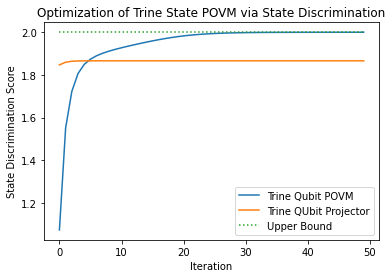

In [5]:
plt.plot(trine_povm_opt_dict["samples"], trine_povm_opt_dict["scores"], label = "Trine Qubit POVM")
plt.plot(trine_proj_opt_dict["samples"], trine_proj_opt_dict["scores"], label = "Trine QUbit Projector")


plt.plot(trine_povm_opt_dict["samples"], [2] * len(trine_povm_opt_dict["samples"]), label = r"Upper Bound", linestyle=":")

plt.title("Optimization of Trine State POVM via State Discrimination")
plt.xlabel("Iteration")
plt.ylabel("State Discrimination Score")
plt.legend()
plt.show()

## Qubit SIC POVM Optimization

We repeat the optimization procedure for the qubit SIC POVM which is 4-state tetrad ensemble,

$$
|\psi_0\rangle = |0\rangle, \quad |\psi_1\rangle = \frac{1}{\sqrt{3}}(|0\rangle + \sqrt{2}|1\rangle),
\quad |\psi_2\rangle = \frac{1}{\sqrt{3}}(|0\rangle + \sqrt{2}e^{i2\pi/3}|1\rangle),
\quad |\psi_2\rangle = \frac{1}{\sqrt{3}}(|0\rangle + \sqrt{2}e^{i4\pi/3}|1\rangle)
$$

In [6]:
def local_RYRZ(settings, wires):
    qml.RY(settings[0],wires=wires[0])
    qml.RZ(settings[1],wires=wires[0])
    
sic_theta = pymath.acos(1/math.sqrt(3))

sic_prep_node = [
    QNopt.PrepareNode(4, [0], local_RYRZ, 2, static_settings=np.array([
        [0,0],[2*sic_theta, 0],[2*sic_theta, 2*np.pi/3],[2*sic_theta, 4*np.pi/3]
    ]))
]

A 1-qubit projective measurement is unable to find the optimal state discrimination score of 2.

In [7]:
%%time

sic_proj_meas_node = [
    QNopt.MeasureNode(1, 4, [0], qml.templates.subroutines.ArbitraryUnitary, 3)
]

sic_proj_ansatz = QNopt.NetworkAnsatz(sic_prep_node, sic_proj_meas_node)

sic_proj_settings = sic_proj_ansatz.rand_scenario_settings()
sic_proj_cost = QNopt.linear_probs_cost(sic_proj_ansatz, np.eye(4), post_processing_map=np.array([
    [1,0],[0,1],[0,0],[0,0]
]))

sic_proj_opt_dict = QNopt.gradient_descent(
    sic_proj_cost,
    sic_proj_settings,
    step_size=0.5,
    num_steps=50,
    sample_width=1,
    verbose=False
)

print("opt_score : ", sic_proj_opt_dict["opt_score"])

opt_score :  1.8164965809277094
CPU times: user 1.24 s, sys: 11 ms, total: 1.25 s
Wall time: 1.26 s


The 2-qubit measurement is able to achieve the optimal state discrimination score of 2.

In [8]:
%%time

sic_meas_node = [
    QNopt.MeasureNode(1, 4, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

sic_povm_ansatz = QNopt.NetworkAnsatz(sic_prep_node, sic_meas_node)

sic_povm_settings = sic_povm_ansatz.rand_scenario_settings()
sic_povm_cost = QNopt.linear_probs_cost(sic_povm_ansatz, np.eye(4))

sic_povm_opt_dict = QNopt.gradient_descent(
    sic_povm_cost,
    sic_povm_settings,
    step_size=0.5,
    num_steps=50,
    sample_width=1,
    verbose=False
)

print("opt_score : ", sic_povm_opt_dict["opt_score"])

opt_score :  1.9999767541138969
CPU times: user 4.04 s, sys: 27.2 ms, total: 4.06 s
Wall time: 4.06 s


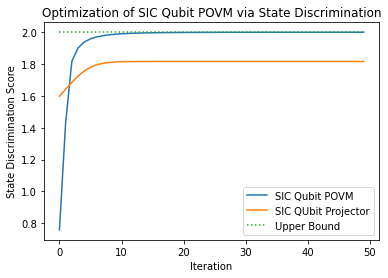

In [9]:
plt.plot(sic_povm_opt_dict["samples"], sic_povm_opt_dict["scores"], label = "SIC Qubit POVM")
plt.plot(sic_proj_opt_dict["samples"], sic_proj_opt_dict["scores"], label = "SIC QUbit Projector")

plt.plot(sic_povm_opt_dict["samples"], [2] * len(sic_povm_opt_dict["samples"]), label = r"Upper Bound", linestyle=":")

plt.title("Optimization of SIC Qubit POVM via State Discrimination")
plt.xlabel("Iteration")
plt.ylabel("State Discrimination Score")
plt.legend()
plt.show()